In [3]:
import time
import intrinio_sdk
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from intrinio_sdk.rest import ApiException
from pprint import pprint

   
intrinio_sdk.ApiClient().configuration.api_key['api_key'] = 'YOUR_API_KEY'

company_api = intrinio_sdk.CompanyApi()
PAGE_SIZE = 100 # number of results to return 
next_page = '' # gets the next page of data from a previous API call (optional)


In [9]:
def getDictionaryFromXLSFile(XLSFile, ratings):
    wordlist = {}
    for i in range(1,8):
        frame = XLSFile.parse(XLSFile.sheet_names[i], header=None)
        frame.columns = ['word']
        frame['score'] = ratings[i - 1]
        dict =frame.set_index('word').to_dict()
        wordlist = {**wordlist, **dict} # append dictionary to wordlist
    return wordlist

In [10]:
def updateLexicon(sia):
    file_path = 'LoughranMcDonald_SentimentWordLists_2018.xlsx'
    file = pd.ExcelFile(file_path)

    wordlist = getDictionaryFromXLSFile(file, [-1,1,-1,-1,1,-1,-1]) # assign scores to words from financial lexiconn
    
    
    sia.lexicon.update(wordlist)

In [11]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
updateLexicon(sia)
# updates sentiment analyzer with words from financial lexicon and their polarity scores

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/gisselle/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
def inPassage(passage, list): 
    for word in list:
        if word in passage:
            return True 
    return False

In [6]:
def createColumn(df, columnName, list):
    df[columnName] = df['summary'].apply(inPassage, args=(list,))

In [7]:
# create dictionaries of words relating to each pillar of ESG. code can be improved by adding to these
eWords = {'environment', 'climate', 'sustainable', 'sustainability', 'green', 'planet'}
sWords = {'social','community', 'responsibility', 'philanthropy', 'charity'}
gWords = {'governance', 'board', 'administration', 'organization', 'conduct'}


In [8]:
def getSentimentScore(passage):
    try:
        score = sia.polarity_scores(str(passage))['compound']
    except TypeError:
        score = 0
    return score

In [9]:
def getESGscore(ticker):
    try:
        api_response = company_api.get_company_news(ticker, page_size=PAGE_SIZE, next_page=next_page)
    except ApiException as e:
        print("Exception when calling CompanyApi->get_company_news: %s\r\n" % e)
    
    df = pd.DataFrame(api_response.news_dict)
    del df['id']
    
    createColumn(df, 'eContent', eWords)
    createColumn(df, 'sContent', sWords)
    createColumn(df, 'gContent', gWords)
    
    df['sentiment'] = df.summary.apply(getSentimentScore)
    
    # define the scores as the sum of the sentiments of the articles containing content relating to env, soc or gov divided by total number of articles fetched
    eScore = df[df['eContent'] == True].sum()['sentiment'] / PAGE_SIZE
    sScore = df[df['sContent'] == True].sum()['sentiment'] / PAGE_SIZE
    gScore = df[df['gContent'] == True].sum()['sentiment'] / PAGE_SIZE
    
    return [eScore, sScore, gScore]


In [13]:
scores = getESGscore(input('Please enter a ticker: '))
print("Environment: {0} Social: {1} Governance: {2}".format(scores[0], scores[1], scores[2]))

Please enter a ticker: JPM
Environment: 0.010341999999999997 Social: 0.0018340000000000012 Governance: 0.048572000000000004


[[0.009984, 0.029369999999999997, 0.059368], [0.0, 0.061084000000000006, 0.065648], [0.008248, 0.0, 0.0012009999999999998], [0.059720999999999996, 0.028205, 0.09254100000000001], [0.060372, 0.008926, 0.027889], [0.010341999999999997, 0.0018340000000000012, 0.048572000000000004], [0.015872999999999998, 0.050464, 0.029830000000000002]]


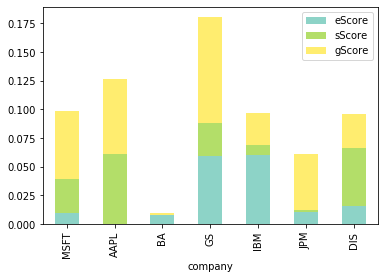

In [12]:
import numpy as np
import matplotlib.pyplot as plt

companies = ['MSFT', 'AAPL', 'BA', 'GS', 'IBM', 'JPM', 'DIS']
scoreList = []

for company in companies:
    scoreList.append(getESGscore(company))
    
print(scoreList)

esgData = pd.DataFrame(scoreList, columns=['eScore', 'sScore','gScore'])
esgData.insert(0, 'company', companies)
esgData

esgData.plot(kind='bar', x='company', stacked=True, cmap='Set3')
